<a href="https://colab.research.google.com/github/fAikoH-dot/TCC-v1/blob/main/prophet/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.24
    Uninstalling holidays-0.24:
      Successfully uninstalled holidays-0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
greykite 1.0.0 requires holidays<0.25, but you have holidays 0.60 which is incompatible.


In [1]:
!pip install python-bcb

In [62]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

In [16]:
df = pd.read_csv('sample_data/Soja_v1.csv', sep=";")
df = df.sort_values(by='Data').reset_index(drop=True)
df.rename(columns={"Data":"ds", "Estadual":"y"}, inplace=True)
df.head()

,ds,Cultivo,y,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0


In [17]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [88]:
clima = pd.read_csv("sample_data/MT_dados.csv", sep=';')
clima.rename(columns={"PRECIPITACAO TOTAL":"precipitacao", "TEMPERATURA MEDIA":"temperatura"}, inplace=True)

clima["precipitacao"] = clima.precipitacao.str.replace(',', '.')
clima["temperatura"] = clima.temperatura.str.replace(',', '.')

clima.bfill(inplace=True)
clima.head()

,Data Medicao,precipitacao,temperatura
0,31/03/2004,175.4,24.9
1,30/04/2004,175.4,24.5
2,31/05/2004,23,21.7
3,30/06/2004,18.8,22.1
4,31/07/2004,38,22.2


In [89]:
df["USD"] = df_usd["USD"]
df["Precipitacao"] = clima["precipitacao"].astype(float)
df["Temperatura"] = clima["temperatura"].astype(float)
df['lag_Estadual'] = df['y'].shift(1)
df['lag_Estadual'] = df['lag_Estadual'].bfill()
df.head()

,ds,Cultivo,y,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0,2.905457,175.4,24.9,45.3777
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0,2.905985,175.4,24.5,45.3777
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0,3.100419,23.0,21.7,45.9456
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0,3.129148,18.8,22.1,44.8723
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0,3.036777,38.0,22.2,38.5913


In [54]:
def plot_predictions(testing_dates, y_test, prediction):
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
    _, ax = plt.subplots(figsize=(10, 5))
    df_test.plot(ax=ax, label="Actual", x="date", y="actual")
    df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
    plt.legend(["Actual", "Prediction"])
    plt.show()

In [63]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

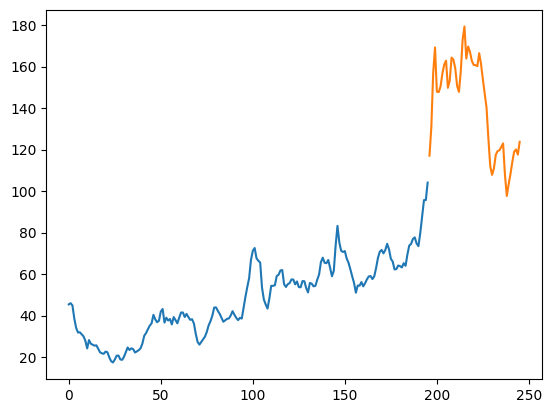

In [21]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.ds

plt.plot(train.y)
plt.plot(test.y)

# Univariado

In [72]:
m = Prophet()
m.fit(train)

# m.params

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_08c2067/jau5wlf8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_08c2067/p05q09gc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73380', 'data', 'file=/tmp/tmp_08c2067/jau5wlf8.json', 'init=/tmp/tmp_08c2067/p05q09gc.json', 'output', 'file=/tmp/tmp_08c2067/prophet_modellchxsnha/prophet_model-20241114112811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:28:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [74]:
forecast = m.predict(test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,76.955598,66.039736,86.699366
1,2020-09-01,78.499337,68.371873,89.118654
2,2020-10-01,78.571636,67.786601,89.207593
3,2020-11-01,78.858561,68.837942,89.193970
4,2020-12-01,78.266230,67.757645,87.884642


In [75]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

,ds,y,yhat
0,2020-08-01,117.0222,76.955598
1,2020-09-01,130.8449,78.499337
2,2020-10-01,156.7972,78.571636
3,2020-11-01,169.1946,78.858561
4,2020-12-01,147.9145,78.266230


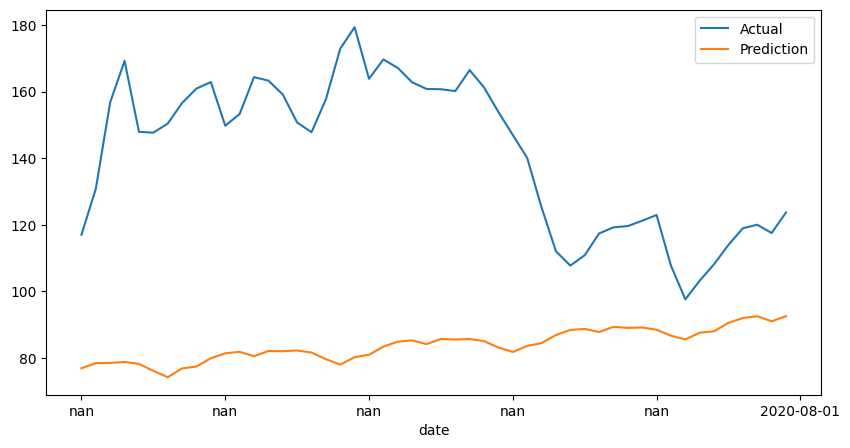

MAE: 57.66430180517358
RMSE: 63.165138002613844
MAPE: 0.38705825934297705
R-Squared: -6.768006728391079


In [76]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

# Multivariado

In [100]:
m = Prophet()
m.add_regressor('USD')
m.add_regressor('País')
m.add_regressor('Último')
m.add_regressor('Máxima')
m.add_regressor('lag_Estadual')
m.fit(train)

# m.params

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_08c2067/2gtyaekr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_08c2067/yqm4qn9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18400', 'data', 'file=/tmp/tmp_08c2067/2gtyaekr.json', 'init=/tmp/tmp_08c2067/yqm4qn9j.json', 'output', 'file=/tmp/tmp_08c2067/prophet_modelw884rcz4/prophet_model-20241114113404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:34:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:34:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [101]:
test_1 = test[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']]
test_1.head()

,ds,USD,País,Último,Máxima,lag_Estadual
0,2020-08-01,5.280191,113.3375,95250.00000,96688.00000,104.0607
1,2020-09-01,5.461233,128.3004,1.02175,1.04650,117.0222
2,2020-10-01,5.399486,147.4121,1.05688,1.09388,130.8449
3,2020-11-01,5.625790,157.3982,1.16875,1.19962,156.7972
4,2020-12-01,5.417835,140.9301,1.31025,1.32060,169.1946


In [40]:
# future = m.make_future_dataframe(periods=len(test_1), freq='MS')
# future.head()

In [102]:
forecast = m.predict(test_1)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,111.210160,109.429869,113.211893
1,2020-09-01,128.217146,126.305073,129.991518
2,2020-10-01,148.017217,146.148636,149.905533
3,2020-11-01,160.421882,158.443103,162.413621
4,2020-12-01,145.689398,143.715547,147.553280


In [103]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y", "País", "USD"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

,ds,y,País,USD,yhat
0,2020-08-01,117.0222,113.3375,5.280191,111.210160
1,2020-09-01,130.8449,128.3004,5.461233,128.217146
2,2020-10-01,156.7972,147.4121,5.399486,148.017217
3,2020-11-01,169.1946,157.3982,5.625790,160.421882
4,2020-12-01,147.9145,140.9301,5.417835,145.689398


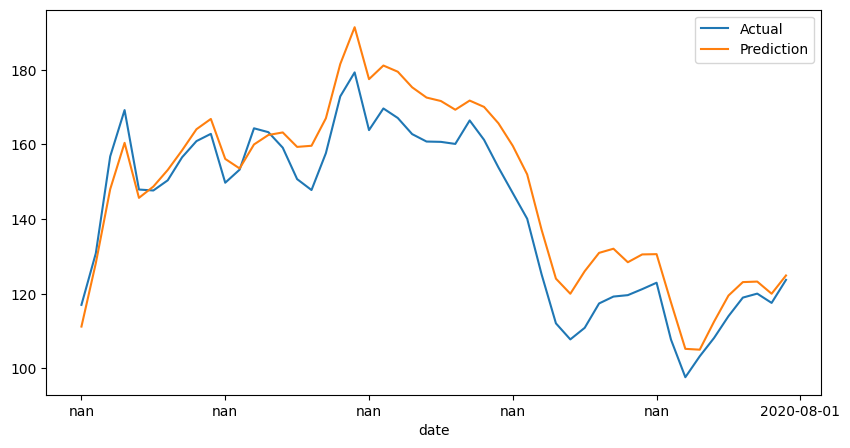

MAE: 7.674367687483682
RMSE: 8.762417519859609
MAPE: 0.05564253658955371
R-Squared: 0.8505132911431065


In [104]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)